In [1]:
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import tqdm
import datasets
from utils import get_params_count_summary
import json
import time
import copy

import pprint
pp = pprint.PrettyPrinter(width=128, compact=True)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
DEVICE = "cuda"

import sys
sys.path.append('segmentation/')
from segmentation import Segmenter, visualized_masks


import datasets
from data.sharegpt4v import ShareGPT4V

from transformers import CodeGenTokenizerFast
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pycocotools.mask as mask_util
import pickle


/home/dchenbs/anaconda3/envs/seq2seq-ae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
dir_mapping = {
    'sam/images': '/home/dchenbs/workspace/datasets/sa1b',
    'coco/train2017': '/home/dchenbs/workspace/datasets/coco2017/images/train2017',
    'llava/llava_pretrain/images': '/home/dchenbs/workspace/datasets/sharegpt4v/LLaVA-Pretrain',
    'wikiart/images': '/home/dchenbs/workspace/datasets/sharegpt4v/WebData/wikiart/images',
    'share_textvqa/images': '/home/dchenbs/workspace/datasets/sharegpt4v/WebData/share_textvqa/images',
    'web-celebrity/images': '/home/dchenbs/workspace/datasets/sharegpt4v/WebData/web-celebrity/images',
        'Choi_Min-sik': 'Choi_Min_sik', 
        'Lee_Byung-hun': 'Lee_Byung_hun',
    'web-landmark/images': '/home/dchenbs/workspace/datasets/sharegpt4v/WebData/web-landmark/images',
    'vg/VG_100K': '/home/dchenbs/workspace/datasets/VisualGenome/VG_100K',
    'vg/VG_100K_2': '/home/dchenbs/workspace/datasets/VisualGenome/VG_100K_2',
    'gqa/images': '/home/dchenbs/workspace/datasets/gqa/images',
    'ocr_vqa/images': '/home/dchenbs/workspace/datasets/sharegpt4v/ocr_vqa/images',
    'textvqa/train_images': '/home/dchenbs/workspace/datasets/sharegpt4v/textvqa/train_images',
}


sharegpt4v_path = '/home/dchenbs/workspace/datasets/sharegpt4v/ShareGPT4V'

annotation_file = os.path.join(sharegpt4v_path, 'sharegpt4v_instruct_gpt4-vision_cap100k.json')
# annotation_file = os.path.join(sharegpt4v_path, 'share-captioner_coco_lcs_sam_1246k_1107.json')
# annotation_file = os.path.join(sharegpt4v_path, 'sharegpt4v_mix665k_cap23k_coco-ap9k_lcs3k_sam9k_div2k.json')

dataset = ShareGPT4V(annotation_file, dir_mapping)
failed_samples = dataset.validate_exist()

Total samples: 102025, after removing text-only samples: 102025


100%|██████████| 102025/102025 [00:00<00:00, 174975.76it/s]

Found 0 samples failed to load.


### Model

In [3]:
from model.modeling_multimodal_phi2 import *
model = PhiForMultimodal.from_pretrained(
    "microsoft/phi-2",
    w_segment_loss=1.0,
    w_bbox_loss=1/(1000*1000),
    seqae_batch_size=32,
    ).to(DEVICE)

model.load_seqae('/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/Jan02_11-49-33_host19-SA1B-[327MB-16queries-1024]-[lr1e-05-bs16x1step-8gpu]/checkpoints/checkpoint_step1950k')

config.json: 100%|██████████| 863/863 [00:00<00:00, 2.06MB/s]
You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.
generation_config.json: 100%|██████████| 124/124 [00:00<00:00, 792kB/s]


### Tokenizer

In [4]:
class MultimodalTokenizer(CodeGenTokenizerFast):

    def __init__(self, segmenter, seqae_config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.segmenter = segmenter
        self.seqae_config = seqae_config

        self.start_token = "<|startofimage|>"
        self.end_token = "<|endofimage|>"
        self.seg_token = "<|seg|>"
        self.add_tokens([self.start_token, self.end_token, self.seg_token])
        self.pad_token = self.eos_token
        self.cache = {}

    def load_cached_segments(self, cached_segments):
        if cached_segments.endswith('.pkl'):
            with open(cached_segments, 'rb') as f:
                cache = pickle.load(f)
        else:
            cache_files = os.listdir(cached_segments)
            cache = {}
            for cache_file in cache_files:
                if cache_file.endswith('.pkl'):
                    with open(os.path.join(cached_segments, cache_file), 'rb') as f:
                        this_cache = pickle.load(f)
                        cache.update(this_cache)
                        print(f'added {len(this_cache)} cached segments from {cache_file}, total {len(cache)} cached segments now.')

        for k, v in cache.items():
            if k not in self.cache:
                self.cache[k] = v

        print(f'Loaded {len(cache)} cached segments from {cached_segments}, total {len(self.cache)} cached segments now.')

    def get_sequences_and_bboxes(self, masks, image):

        def resize(segment):
            h = segment['patch'].size(1)
            w = segment['patch'].size(2)
            if h * w > (self.seqae_config.data_seq_length):
                ratio_to_maxlength = np.sqrt(self.seqae_config.data_seq_length / (h * w))
                h = int(h * ratio_to_maxlength)
                w = int(w * ratio_to_maxlength)
                segment['patch'] = torchvision.transforms.Resize([h, w])(segment['patch'])
                segment['segmentation'] = torchvision.transforms.Resize([h, w])(segment['segmentation'][None, :, :])[0]

            return segment
        
        def encode_to_sequence(segment):            
            """
            # the following function is used during traning SeqAE. Now there is a faster tensor based implementation (encode_to_sequence)
            # so this one is deprecated, but I keep it here for reference
            def encode_to_sequence_slow(segment):
                # segment['patch'] is torch tensor with shape (C, H, W)
                h, w = segment['patch'].shape[1:]
                sequence = []
                for i in range(h):
                    for j in range(w):
                        pixel_data = segment['patch'][:, i, j]# / 255.0
                        is_rightmost = 1 if j == w - 1 else 0
                        is_non_masked = int(segment['segmentation'][i, j])
                        sequence.append(pixel_data.tolist() + [is_rightmost, is_non_masked])
                sequence = np.array(sequence) 

                # pad the sequence to max_seq_length with zeros
                if len(sequence) < self.seqae_config.data_seq_length:
                    sequence = np.concatenate((sequence, np.zeros((self.seqae_config.data_seq_length - len(sequence), self.seqae_config.input_channels))))

                # add the query place holder to the end of the sequence
                sequence = np.concatenate((sequence, np.zeros((self.seqae_config.num_queries, self.seqae_config.input_channels))))
                # add one all zero column to the start 
                sequence = np.concatenate((np.zeros((1, sequence.shape[1])), sequence), axis=0)

                return torch.from_numpy(sequence)
          """  
            
            # segment['patch'] is torch tensor with shape (C, H, W)
            patch = segment['patch']# / 255.0
            h, w = patch.shape[1:]

            # Create is_rightmost and is_non_masked tensors
            is_rightmost = torch.zeros((h, w), dtype=torch.float32)
            is_rightmost[:, -1] = 1
            is_non_masked = segment['segmentation'].float()
            
            # stack them together with patch
            patch = patch.permute(1, 2, 0) # (H, W, C)
            patch = patch.reshape(-1, patch.shape[-1])  # (H*W, C)
            is_rightmost = is_rightmost.reshape(-1, 1) # (H*W, 1)
            is_non_masked = is_non_masked.reshape(-1, 1) # (H*W, 1)
            sequence = torch.cat([patch, is_rightmost, is_non_masked], dim=-1).view(-1, 5)

            # pad the sequence to max_seq_length with zeros
            if len(sequence) < self.seqae_config.data_seq_length:
                sequence = torch.cat((sequence, torch.zeros((self.seqae_config.data_seq_length - len(sequence), self.seqae_config.input_channels))))

            # add the query place holder to the end of the sequence
            sequence = torch.cat((sequence, torch.zeros((self.seqae_config.num_queries, self.seqae_config.input_channels))))

            # add one all zero column to the start 
            sequence = torch.cat((torch.zeros((1, sequence.shape[1])), sequence), dim=0)

            return sequence

        segment_sequences = []
        bboxes = []

        for mask in masks:
            segmentation = mask["segmentation"]

            bbox = mask["bbox"]
            bbox[2] = 1 if bbox[2] == 0 else bbox[2]
            bbox[3] = 1 if bbox[3] == 0 else bbox[3]
            x, y, w, h = bbox

            segment = {
                "patch": image[:, y:y+h, x:x+w],
                "segmentation": segmentation[y:y+h, x:x+w],
            }

            assert segment['patch'].size(1) == segment['segmentation'].size(0) and segment['patch'].size(2) == segment['segmentation'].size(1)

            segment = resize(segment)
            segment['patch'] = segment['patch'] * segment['segmentation'][None, :, :]
            
            segment_sequence = encode_to_sequence(segment)
            segment_sequences.append(segment_sequence)
            bboxes.append(bbox)

        segment_sequences = torch.stack(segment_sequences, dim=0)
        bboxes = torch.tensor(bboxes)
        return segment_sequences, bboxes
    
    def get_segmentation(self, image_path):
        if image_path in self.cache:
            masks = copy.deepcopy(self.cache[image_path])
            for mask in masks:
                mask['segmentation'] = mask_util.decode(mask['segmentation']).astype(bool)
        else:
            masks = self.segmenter(image_path)
        
        for mask in masks:
            if type(mask['segmentation']) == np.ndarray:
                mask['segmentation'] = torch.from_numpy(mask['segmentation'])
        
        return masks
    

    def __call__(self, texts, *args, **kwargs):
        img_path_start, img_path_end = "<img_path>", "</img_path>"
        all_sequences, all_bboxes, all_texts = [], [], []

        for text in texts:
            this_text_sequences, this_text_bboxes = [], []
            if img_path_start in text and img_path_end in text:
                while img_path_start in text and img_path_end in text:
                    start_index, end_index = text.index(img_path_start), text.index(img_path_end)
                    image_path = text[start_index + len(img_path_start):end_index]

                    masks = self.get_segmentation(image_path)
                    masks.sort(key=lambda x: x['area'], reverse=True)

                    h, w = masks[0]['segmentation'].shape[:2]
                    image = torchvision.transforms.ToTensor()(Image.open(image_path).convert('RGB'))
                    image = torchvision.transforms.Resize([h, w])(image)

                    segment_sequences, bboxes = self.get_sequences_and_bboxes(masks, image)
                    this_text_sequences.append(segment_sequences)
                    this_text_bboxes.append(bboxes)

                    # Replace image path with segment tokens <|seg|>
                    text = text[:start_index] + self.start_token + self.seg_token*len(masks) + self.end_token + text[end_index + len(img_path_end):]

                this_text_sequences = torch.stack(this_text_sequences)
                this_text_bboxes = torch.stack(this_text_bboxes)

            all_texts.append(text)
            all_sequences.append(this_text_sequences)
            all_bboxes.append(this_text_bboxes)

        inputs = super().__call__(all_texts, *args, **kwargs)

        inputs['segment_sequences'] = all_sequences # a list of `batch_size` elements, each element is a tensor of [image_num, num_segments, seq_length, input_channels]
        inputs['bboxes'] = all_bboxes # a list of `batch_size` elements, each element is a tensor of [image_num, num_segments, 4] representing bounding boxes in x, y, w, h

        return inputs
    
    
    def decode_image(self, segment_sequences, bboxes):

        # segment_sequences: torch tensor [num_segments, seq_length, input_channels]
        # bboxes: torch tensor [num_segments, 4] (x, y, w, h)

        # first, get the image size by finding the largest x+w and y+h
        # rightmost = torch.max(bboxes[:, 0] + bboxes[:, 2])
        # bottommost = torch.max(bboxes[:, 1] + bboxes[:, 3])
        rightmost = torch.max(bboxes[:, 2])+1
        bottommost = torch.max(bboxes[:, 3])+1
        canvas = np.zeros((int(bottommost), int(rightmost), 3)).astype(np.uint8)

        for i in range(len(segment_sequences)):
            x, y, w, h = bboxes[i]
            segment, mask = self.decode_image_from_seq(segment_sequences[i].numpy())
            segment = cv2.resize(segment, (int(w), int(h)))
            mask = cv2.resize(mask, (int(w), int(h)))
            # canvas[y:y+h, x:x+w, :] = segment * mask[:, :, None]

            # only modify the canvas where mask is 1
            canvas[y:y+h, x:x+w, :] = canvas[y:y+h, x:x+w, :] * (1 - mask[:, :, None]) + segment * mask[:, :, None]


        return canvas


    def decode_image_from_seq(self, data_seq, new_line_threshold=0.5, mask_threshold=0.5):
        # input: seq (tensor of shape (seq_length, 5))

        # first position is <start-of-sequence> token and should be ignored
        rgb_seq = data_seq[1:, :3]
        new_line_seq = data_seq[1:, 3] > new_line_threshold
        mask_seq = data_seq[1:, 4] > mask_threshold

        # find the last positive element in new_line_seq, and use it to truncate data and sequences
        if np.sum(new_line_seq) > 0:
            effective_seq_length = np.nonzero(new_line_seq)[0][-1] + 1 # +1 because we ignored the first token 
        else:
            effective_seq_length = len(new_line_seq)

        rgb_seq = rgb_seq[:effective_seq_length] * 255
        new_line_seq = new_line_seq[:effective_seq_length]
        mask_seq = mask_seq[:effective_seq_length]

        if np.sum(new_line_seq) > 0:
            # height is the number of non zero element in shape_encoding_seq
            height_decoded = np.sum(new_line_seq)

            # width is the largest interval between two consecutive non zero elements in shape_encoding_seq
            new_line_indices = np.where(new_line_seq)[0]
            new_line_indices = np.insert(new_line_indices, 0, 0)
            diffs = np.diff(new_line_indices)
            width_decoded = max(1, np.max(diffs))
        else:
            # no effective new line token, so we assume the height~width ratio is 1:1
            height_decoded = int(math.sqrt(len(rgb_seq)))
            width_decoded = len(rgb_seq) // height_decoded

            # add positive new line token to new_line_seq, every width_decoded elements
            new_line_seq[width_decoded-1::width_decoded] = 1

            # in case of width_decoded * height_decoded < len(rgb_seq), truncate
            effective_seq_length = width_decoded * height_decoded
            rgb_seq = rgb_seq[:effective_seq_length]
            new_line_seq = new_line_seq[:effective_seq_length]
            mask_seq = mask_seq[:effective_seq_length]

        width_decoded += 1 # don't know why, but fix bug
        
        segment = np.zeros((height_decoded, width_decoded, 3))
        mask = np.zeros((height_decoded, width_decoded))

        # split segment_data into parts according to new_line_seq=True positions (splited parts could be in different length)
        split_indices = np.where(new_line_seq)[0] + 1 
        splited_rgb_lines = np.split(rgb_seq, split_indices)
        splited_mask_lines = np.split(mask_seq, split_indices)
        splited_rgb_lines = [x for x in splited_rgb_lines if len(x) > 0]
        splited_mask_lines = [x for x in splited_mask_lines if len(x) > 0]

        for row_id in range(len(splited_rgb_lines)):
            rgb_line = splited_rgb_lines[row_id]
            mask_line = splited_mask_lines[row_id]
            segment[row_id, :len(rgb_line), :] = rgb_line
            mask[row_id, :len(mask_line)] = mask_line
        
        # apply mask to the segment: set all masked pixels to 255
        segment[mask == 0] = 255
        segment = segment[:, :-1, :]
        mask = mask[:, :-1]
        segment = segment.astype(np.uint8)

        return segment, mask

# with open('segmentation/mobile_sam_v2_l2.json', 'r') as f:
#     config = json.load(f)
#     pprint.pprint(config)
# segmenter = Segmenter(config['model_name'], config['checkpoint'], **config['kwargs'])

segmenter = None

tokenizer = MultimodalTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True, segmenter=segmenter, seqae_config=model.seqae.config)
tokenizer.load_cached_segments(f'/home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/sharegpt4v_instruct_gpt4-vision_cap100k')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CodeGenTokenizer'. 
The class this function is called from is 'MultimodalTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


added 10000 cached segments from part0.pkl, total 10000 cached segments now.
added 10000 cached segments from part3.pkl, total 20000 cached segments now.
added 10000 cached segments from part6.pkl, total 30000 cached segments now.
added 10000 cached segments from part4.pkl, total 40000 cached segments now.
added 10000 cached segments from part1.pkl, total 50000 cached segments now.
added 10000 cached segments from part7.pkl, total 60000 cached segments now.
added 7293 cached segments from part8.pkl, total 67293 cached segments now.
added 10000 cached segments from part5.pkl, total 77293 cached segments now.
added 10000 cached segments from part2.pkl, total 87293 cached segments now.
Loaded 87293 cached segments from /home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/sharegpt4v_instruct_gpt4-vision_cap100k, total 87293 cached segments now.


In [5]:

print(len(dataset))
dataset_samples = []
for i in tqdm.tqdm(range(len(dataset))):
    img_path = dataset.samples[i]['image']

    if 'sam/images' in img_path:
        relative_img_path = img_path.split('sam/images/')[-1]
        img_path = img_path.replace(relative_img_path, dataset.sam_dir_mapping[relative_img_path])

    for org, new in dataset.dir_mapping.items():
        img_path = img_path.replace(org, new)

    if img_path in tokenizer.cache:
        dataset_samples.append(dataset.samples[i])

dataset.samples = dataset_samples
print(len(dataset))


102025


100%|██████████| 102025/102025 [00:00<00:00, 366982.72it/s]

102022


/home/dchenbs/anaconda3/envs/seq2seq-ae/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


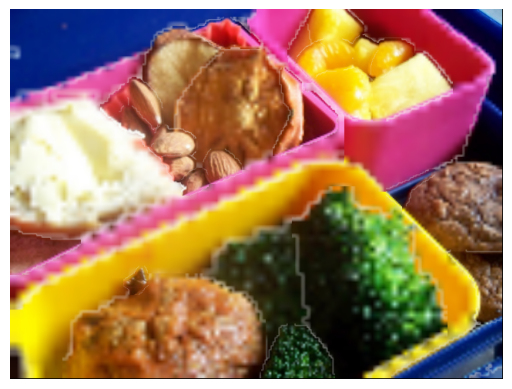

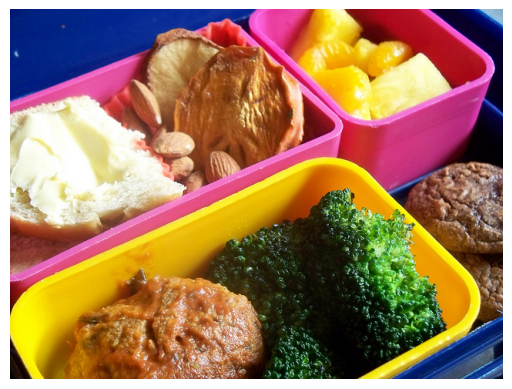

In [6]:
inputs = tokenizer([dataset[0]])

canvas = tokenizer.decode_image(inputs['segment_sequences'][0][0], inputs['bboxes'][0][0])

plt.imshow(canvas)
plt.axis('off')
plt.show()

img_path = dataset.samples[0]['image']
for org, new in dataset.dir_mapping.items():
    img_path = img_path.replace(org, new)
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.show()


In [8]:

model.resize_token_embeddings(len(tokenizer))
model.special_token_id_mappinmg = {
    "<|startofimage|>": tokenizer.convert_tokens_to_ids("<|startofimage|>"),
    "<|endofimage|>": tokenizer.convert_tokens_to_ids("<|endofimage|>"),
    "<|seg|>": tokenizer.convert_tokens_to_ids("<|seg|>"),
    "<|endoftext|>": tokenizer.convert_tokens_to_ids("<|endoftext|>"),
    "[PAD]": tokenizer.convert_tokens_to_ids("[PAD]"),
}

### Trainer

In [9]:
from transformers import (
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, PeftModel, get_peft_model

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules='transformer.*(Wqkv|out_proj)$',
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

for name, param in model.named_parameters():
    if 'seqae' in name:
        param.requires_grad = False
    if 'seqae' not in name and 'transformer' not in name:
        param.requires_grad = True

print(get_params_count_summary(model, max_name_len=96))

| Module                                                                                           | Trainable  |           Shape |  Param Count |
----------------------------------------------------------------------------------------------------------------------------------------------------------------
| base_model.model.transformer.embd.wte.weight                                                     | False      |   (50298, 2560) |  128,762,880 |
| base_model.model.transformer.h.0.ln.weight                                                       | False      |         (2560,) |        2,560 |
| base_model.model.transformer.h.0.ln.bias                                                         | False      |         (2560,) |        2,560 |
| base_model.model.transformer.h.0.mixer.Wqkv.base_layer.weight                                    | False      |    (7680, 2560) |   19,660,800 |
| base_model.model.transformer.h.0.mixer.Wqkv.base_layer.bias                                      | Fal

In [10]:
from transformers import PreTrainedTokenizerBase
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union

@dataclass
class DataCollatorForMultimodal:

    tokenizer: PreTrainedTokenizerBase
    
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        batch = self.tokenizer(features, return_tensors="pt", padding='max_length', truncation=True)
        if "label" in batch:
            batch["labels"] = batch["label"]
            del batch["label"]
        if "label_ids" in batch:
            batch["labels"] = batch["label_ids"]
            del batch["label_ids"]
        return batch
    
data_collator = DataCollatorForMultimodal(tokenizer)

In [11]:
training_arguments = TrainingArguments(
        output_dir="runs/phi-2-multimodal",
        per_device_train_batch_size=1,
        gradient_accumulation_steps=8,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="steps",
        save_steps = 500,
        logging_steps=1,
        max_steps=2000,
        num_train_epochs=100,
        push_to_hub=False,
        bf16=True,
    )

class MyTrainer(Trainer):

    # init
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)

        with self.compute_loss_context_manager():
            loss, outputs = self.compute_loss(model, inputs, return_outputs=True)

        if self.args.n_gpu > 1:
            loss = loss.mean()  # mean() to average on multi-gpu parallel training

        if self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            self.accelerator.backward(loss)

        self.log(outputs['profiling'])

        return loss.detach() / self.args.gradient_accumulation_steps

trainer = MyTrainer(
    model=model,
    train_dataset=dataset,
    # eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=training_arguments,
)
torch.cuda.empty_cache()
trainer.train()

/home/dchenbs/workspace/Seq2Seq-AutoEncoder/model/modeling_multimodal_phi2.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seg_pos = torch.where(torch.tensor(input_ids[sample_idx]) == torch.tensor(self.special_token_id_mappinmg["<|seg|>"]))[0].tolist()


Step,Training Loss
100,1.438100
200,0.855700
300,0.791300
400,0.759300


In [ ]:
# inputs  = tokenizer([
#     # 'This is an image: <img_path>/home/dchenbs/workspace/datasets/CLEVR_v1.0/images/test/CLEVR_test_000000.png</img_path><|endoftext|>',
#     dataset[-1]['text'].split('### AI: \n')[0] + '### AI: \n'
#     ], return_tensors="pt", return_attention_mask=False, padding=True)

# print(tokenizer.decode(inputs['input_ids'][0]))

# inputs['input_ids'] = inputs['input_ids'].to(DEVICE)

# outputs = model.generate(**inputs, max_length=512)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)